# Lab Manual: Practical Word Embeddings

This lab will guide you through the fundamentals of word embeddings and their practical application in building a semantic search system.

Unlike traditional keyword search, semantic search understands the meaning and context behind your query.

## Lab Objective:
### Build a `semantic search system` that finds documents `based on meaning` rather than keyword matching.


<br>

## Part 1: Setting Up and Exploring the Building Blocks

`Concept:` A word embedding is a numerical vector representation of a word. The magic is that these vectors capture semantic relationships. 
<br>For example, the vector for `king` - `man` + `woman` results in a vector very close to that of `queen`. 
<br>We'll use a pre-trained model called `GloVe (Global Vectors for Word Representation)`, which was trained on a massive dataset from `Wikipedia`.

`Gensim` is an open-source Python library designed for topic modeling and document similarity analysis.

In [ ]:
# Install required libraries
!pip install gensim 

In [18]:
# Import the gensim downloader API to fetch pre-trained models
import gensim.downloader as api

In [19]:
# Let's see what models are available. There are many, trained on different data!
available_models = list(api.info()['models'].keys())

print("Available models:")
for model in available_models:
    print(model)

Available models:
fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


We'll load `glove-wiki-gigaword-300`. <br>

This is a great choice because it's powerful but small enough to run quickly. <br>

The `300` means each word is represented by a `300-dimensional vector` <br>

In [ ]:
import os
import shutil

# Clear corrupted cache
cache_dir = os.path.join(os.path.expanduser("~"), "gensim-data")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("Cache cleared!")

Cache cleared!


In [21]:
word_vectors = api.load("glove-wiki-gigaword-300")  # Smaller, faster model

[==================================================] 100.0% 376.1/376.1MB downloaded


### Basic exploration

In [22]:
# Let's explore some basic properties of the model

print("Vocabulary size:", len(word_vectors.key_to_index)) # How many unique words it knows
print("Vector dimension:", word_vectors.vector_size) # The size of the vector for each word

Vocabulary size: 400000
Vector dimension: 300


### Exploring Word Similarities

We can use the model to find words with similar meanings. 
<br>The `most_similar` function finds the words whose vectors are closest to our target word's vector in the 300-dimensional space.

In [ ]:
def explore_similarity(word):
    """A helper function to print the most similar words to a given word."""
    try:
        similar = word_vectors.most_similar(word, topn=5)
        print(f"Words similar to '{word}':")
        # The score is the cosine similarity, ranging from -1 (opposite) to 1 (identical)
        for w, score in similar:
            print(f"  {w}: {score:.3f}")
    except KeyError:
        print(f"'{word}' is not in the vocabulary.")

explore_similarity("uganda")
explore_similarity("education")
explore_similarity("innovation")

Words similar to 'uganda':
  tanzania: 0.776
  ugandan: 0.753
  kenya: 0.747
  zambia: 0.735
  rwanda: 0.717
Words similar to 'education':
  educational: 0.737
  schools: 0.679
  teaching: 0.646
  health: 0.640
  curriculum: 0.640
Words similar to 'innovation':
  innovations: 0.701
  technological: 0.691
  creativity: 0.684
  entrepreneurship: 0.655
  innovative: 0.631


## Part 2: Document Similarity using Embeddings

We have vectors for words, but how do we represent a whole document? The simplest, yet surprisingly effective, method is 
- to average the vectors of all the words in the document. This creates a single vector representing the document's `semantic center of gravity.`

To compare how similar our query document is to our other documents, we'll use `Cosine Similarity`. 

- This measures the cosine of the angle between two vectors. 
- A value of 1 means they point in the exact same direction (very similar), 
- 0 means they are orthogonal (unrelated), and 
- -1 means they are opposite.

In [24]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re # Import the regular expressions library for better text cleaning

In [25]:
def document_to_vector(doc, word_vectors):
    """
    Converts a document to an average vector of its words.
    This version includes basic text cleaning.
    """
    # 1. Clean the text: remove punctuation and convert to lowercase
    doc = re.sub(r'[^\w\s]', '', doc).lower()
    
    # 2. Split into words (tokens)
    words = doc.split()
    
    # 3. Look up the vector for each word in our model's vocabulary
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    
    # 4. If no words are found in the vocabulary, return a zero vector
    if not vectors:
        return np.zeros(word_vectors.vector_size)
    
    # 5. Average the vectors to get a single representative vector for the document
    return np.mean(vectors, axis=0)

In [26]:
# Our sample "database" of documents about East Africa
documents = [
    "Uganda is working to improve university education and research facilities",
    "Kenyan universities are expanding their artificial intelligence programs",
    "Agricultural innovation is key to economic growth in East Africa",
    "The government is investing in digital infrastructure across the region",
    "Student enrollment in computer science has doubled in recent years"
]

In [27]:
# Convert all our documents into numerical vectors
doc_vectors = [document_to_vector(doc, word_vectors) for doc in documents]

In [28]:
# Our search query
query = "higher education technology in African universities"
query_vector = document_to_vector(query, word_vectors)

# Calculate the cosine similarity between our query vector and all document vectors
# The result is a 2D array, so we grab the first (and only) row with [0]
similarities = cosine_similarity([query_vector], doc_vectors)[0]

print("\nDocument similarities to the query:")
for i, (doc, sim) in enumerate(zip(documents, similarities)):
    print(f"{i+1}. Score: {sim:.3f} - {doc}")


Document similarities to the query:
1. Score: 0.840 - Uganda is working to improve university education and research facilities
2. Score: 0.775 - Kenyan universities are expanding their artificial intelligence programs
3. Score: 0.771 - Agricultural innovation is key to economic growth in East Africa
4. Score: 0.748 - The government is investing in digital infrastructure across the region
5. Score: 0.784 - Student enrollment in computer science has doubled in recent years


Observation: Notice how the top results are about universities and education, even though they don't share many exact keywords with the query. That's semantic search in action!

## Part 3: Building a Semantic Search System

In [29]:
class SemanticSearchEngine:
    """A simple semantic search engine."""
    def __init__(self, word_vectors):
        self.word_vectors = word_vectors
        self.documents = []
        self.doc_vectors = []
    
    def add_document(self, document):
        """Adds a document to the engine's database."""
        self.documents.append(document)
        # We pre-calculate and store the vector to make searching faster
        self.doc_vectors.append(document_to_vector(document, self.word_vectors))
    
    def search(self, query, top_k=3):
        """Searches the documents for the most relevant results to the query."""
        query_vector = document_to_vector(query, self.word_vectors)
        
        # Calculate similarity against all stored document vectors
        similarities = cosine_similarity([query_vector], self.doc_vectors)[0]
        
        # Combine documents with their scores and sort to find the best matches
        results = sorted(zip(self.documents, similarities), 
                         key=lambda item: item[1],  # Sort by the score
                         reverse=True)             # Highest score first
        
        return results[:top_k] # Return the top_k results


In [30]:
# 1. Create an instance of our search engine
search_engine = SemanticSearchEngine(word_vectors)

# 2. Add our documents to the engine
for doc in documents:
    search_engine.add_document(doc)

# 3. Let's test it with a few queries!
test_queries = [
    "university programs",
    "technology investment",
    "agricultural development"
]

for query in test_queries:
    print(f"\n--- Query: '{query}' ---")
    results = search_engine.search(query)
    for doc, score in results:
        print(f"  Score: {score:.3f} - {doc}")


--- Query: 'university programs' ---
  Score: 0.755 - Uganda is working to improve university education and research facilities
  Score: 0.686 - Student enrollment in computer science has doubled in recent years
  Score: 0.664 - Kenyan universities are expanding their artificial intelligence programs

--- Query: 'technology investment' ---
  Score: 0.645 - Agricultural innovation is key to economic growth in East Africa
  Score: 0.635 - The government is investing in digital infrastructure across the region
  Score: 0.610 - Uganda is working to improve university education and research facilities

--- Query: 'agricultural development' ---
  Score: 0.741 - Agricultural innovation is key to economic growth in East Africa
  Score: 0.647 - Uganda is working to improve university education and research facilities
  Score: 0.583 - The government is investing in digital infrastructure across the region


<br>

## Part 4: Visualization of Word Relationships

Our word vectors have `300` dimensions, which we can't possibly visualize. 
<br>We can use a dimensionality reduction technique called `t-SNE (t-Distributed Stochastic Neighbor Embedding)` to project these vectors down to 2D space. 
- This helps us visually confirm that words with similar meanings cluster together.

In [34]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
def plot_word_relationships(words, word_vectors, title):
    """Plots a list of words in 2D space using t-SNE."""
    vectors_list = [word_vectors[word] for word in words if word in word_vectors]
    words_filtered = [word for word in words if word in word_vectors]
    

    # Convert the list of vectors into a 2D NumPy array before passing to t-SNE
    vectors_np = np.array(vectors_list)
    
    # Adjust perplexity to be safe: it must be less than the number of samples
    # A good rule of thumb is between 5 and 50. Let's cap it.
    k = vectors_np.shape[0]
    perplexity_value = min(30, k - 1) # Set perplexity to 30 or less if not enough words
    if k <= 1:
        print(f"Not enough words found in vocabulary for plot '{title}'. Skipping.")
        return

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    
    # Pass the NumPy array to fit_transform
    vectors_2d = tsne.fit_transform(vectors_np)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], color='steelblue')
    
    for i, word in enumerate(words_filtered):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
    
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

In [32]:
def plot_word_relationships(words, word_vectors, title):
    """Plots a list of words in 2D space using t-SNE."""
    # Get the 300-dimensional vectors for our chosen words
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    words_filtered = [word for word in words if word in word_vectors]
    
    # Use t-SNE to reduce the 300 dimensions down to 2
    tsne = TSNE(n_components=2, random_state=42, perplexity=len(words_filtered)-2)
    vectors_2d = tsne.fit_transform(vectors)
    
    # Create the plot
    plt.figure(figsize=(12, 10))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], color='steelblue')
    
    # Annotate each point with its corresponding word
    for i, word in enumerate(words_filtered):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
    
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()


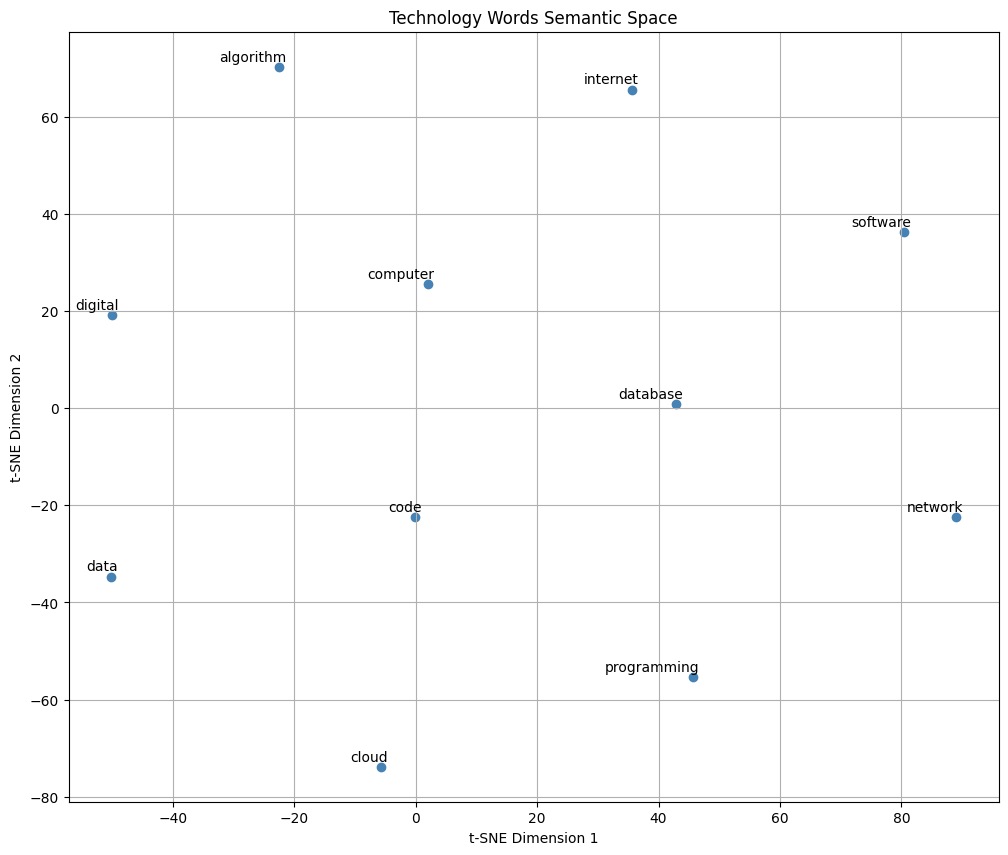

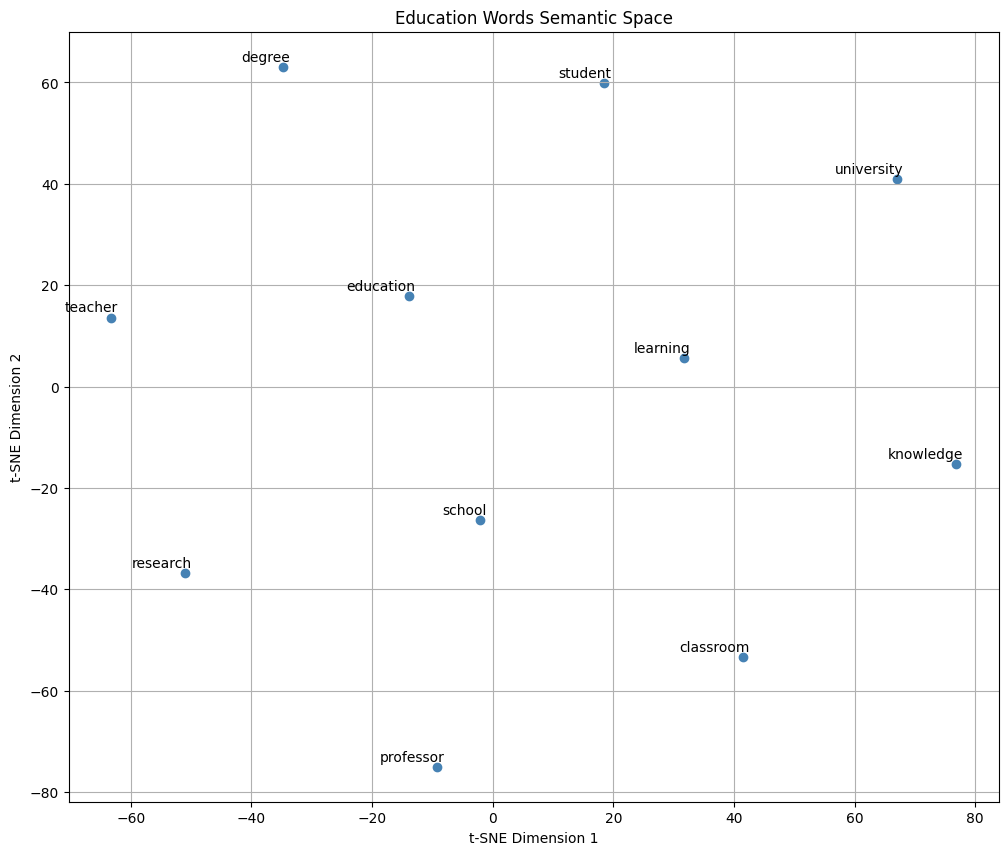

In [36]:
# A list of words related to technology
tech_words = ['computer', 'software', 'internet', 'algorithm', 'data', 
              'programming', 'network', 'digital', 'code', 'database', 'cloud']
plot_word_relationships(tech_words, word_vectors, "Technology Words Semantic Space")

# A list of words related to education
edu_words = ['university', 'education', 'student', 'teacher', 'classroom',
             'learning', 'research', 'knowledge', 'school', 'professor', 'degree']
plot_word_relationships(edu_words, word_vectors, "Education Words Semantic Space")

The main goal of these plots is to take the complex, 300-dimensional vector for each word and 

<br>represent it in a simple 2D space we can actually see. This process is called `dimensionality reduction`. 

<br>The key idea is that words with similar meanings (whose vectors are close in the 300D space) should appear near each other as clusters on this 2D map.

<br>

### Analyzing the Clusters

### Technology Words Semantic Space

`Logical Groupings:`

- code and programming are located very close to each other in the lower half. This is a perfect result, as these concepts are tightly linked.

- computer and software are in the same upper-left quadrant. This makes sense, as one is the hardware that runs the other.

- internet and network are both on the right side of the plot, indicating they share a similar semantic context.

`Conceptual Distinctions:`

- data and database are related, but one is the raw information (data) while the other is the structured system to hold it (database). <br>The plot correctly shows them as distinct points, not on top of each other.

- algorithm is near the top. While it's related to programming and code, it's a more abstract, mathematical concept. 
<br>The plot captures this by placing it in its own space.



### Education Words Semantic Space
`Key Observations:`
- People in Education: Notice how student, teacher, and professor are positioned. teacher and professor are on the left and bottom, while student is at the top. <br>While they are all roles within education, they are distinct, and the plot reflects this.

- Institutions and Concepts: The words school and university are in different locations. This is logical, as they represent different levels of the educational system. <br>Education itself sits centrally, acting as a conceptual anchor for many of the other terms.

- The Learning Process: The words learning and knowledge are grouped on the right side. <br>This makes sense as learning is the process by which one acquires knowledge.

- Formal Recognition: Degree is near the top, close to student and university, which is a strong and logical connection—students attend a university to earn a degree.

## Part 5: Discussion & Limitations

This method is powerful, but it's important to understand its limitations:

- `Loss of Word Order:` Averaging vectors treats a document as a "bag of words." The meaning from word order is lost. "Dog bites man" and "Man bites dog" would have the exact same document vector.

- `Negation is Tricky:` The model doesn't handle negation well. "A good day" and "not a good day" might have very similar vectors.

- `Out-of-Vocabulary (OOV) Words:` The model only knows words it was trained on. New slang, technical jargon, or misspellings will be ignored.

- `Averaging Ambiguity:` If a document contains words with opposite meanings (e.g., "happy" and "sad"), the average vector might be a muddled, meaningless representation in the middle.

#### Practice Scenario & Challenge

#### You are working for a news organization. Your task is to build a tool that helps journalists find articles related to a specific topic, even if they don't use the exact same keywords.

Dataset <br>
You will use the famous `20 Newsgroups` dataset, which is conveniently built into scikit-learn. It contains about 18,000 newsgroup posts on 20 different topics.

Guide Questions
1. Load the Data: Load the data for just two categories: 
    - rec.sport.hockey 
    - talk.politics.guns.

2. Build the Search Engine: Create a new `SemanticSearchEngine` instance and add all the documents from both categories to it.

3. Test Your Engine: Run searches with the following queries and analyze the results. Which category do the top results come from? Do the results make sense?

    - Query 1: protecting constitutional rights

    - Query 2: the playoff season

    - Query 3: violent confrontation